# Imports

In [3]:
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import keras
import nolearn# import xgboost

# Load Images

In [2]:
# Load images first
numImages = len(glob.glob('./images/*jpg'))
images = [None for i in xrange(numImages)]
for fileName in glob.glob('./images/*jpg'):
    fileNum = int(fileName[9:][:-4])
    images[fileNum-1] = np.array(cv2.imread(fileName, 0))
images = np.array(images)

# Load csv data next
train_data = pd.read_csv('data/train.csv').drop(['species'], axis=1).values
train_labels = pd.read_csv('data/train.csv')['species'].values
train_images = [images[int(data[0]-1)] for data in train_data]
train_ids = [data[0] for data in train_data]
train_data = np.delete(train_data, 0, 1)


test_data = pd.read_csv('data/test.csv').values
test_images = [images[int(data[0]-1)] for data in test_data]
test_ids = [data[0] for data in test_data]
test_data = np.delete(test_data, 0, 1)

del images

# Extract Various Manual Features

### Load the manual 3 feature histograms

In [4]:
le= preprocessing.LabelEncoder()
#encode train labels
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)

#separate the 3 histograms
train_margin_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'margin1':'margin64']).values
train_shape_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'shape1':'shape64']).values
train_texture_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'texture1':'texture64']).values

test_margin_data=((pd.read_csv('data/test.csv')).loc[:,'margin1':'margin64']).values
test_shape_data=((pd.read_csv('data/test.csv')).loc[:,'shape1':'shape64']).values
test_texture_data=((pd.read_csv('data/test.csv')).loc[:,'texture1':'texture64']).values

#print train_margin_data.head()
#print train_shape_data.head()
#print train_texture_data.head()

### Define functions for clustering/finding descriptors

In [5]:
def get_descriptor(images, dense=False):
    sift = cv2.xfeatures2d.SIFT_create()
    des_per_Img = np.array([sift.detectAndCompute(img,None)[1] for img in images])
    return des_per_Img
        
def get_clusters(descriptors, vocabSize):
    des_list = np.concatenate(descriptors)

    kmeans = MiniBatchKMeans(vocabSize, batch_size=100)
    kmeans.fit(np.array(des_list))
    
    return kmeans

def get_vocabulary(descriptors, clusters, vocabSize):
    return np.array([normalize(np.histogram(clusters.predict(dscrs), bins=range(vocabSize))[0].reshape(1,-1)).ravel() for dscrs in descriptors])
        

### Get the descriptors for the training/testing of SIFT features

In [6]:
des_list_train = get_descriptor(train_images)
des_list_test = get_descriptor(test_images)

### Cluster the descriptors into a vocabulary

In [7]:
clustering_start_time=time.time()
clusters = get_clusters(des_list_train,150)
clustering_end_time=time.time()
print "Clustering completed in {:2f} seconds".format(clustering_end_time-clustering_start_time)

Clustering completed in 3.969930 seconds


### Retrieve the vocabulary for test/train data

In [8]:
vocab_train = get_vocabulary(des_list_train,clusters,150)
vocab_test = get_vocabulary(des_list_test,clusters,150)

In [9]:
print train_data.shape
print vocab_train.shape
train_set = np.append(train_data,vocab_train,axis=1)
test_set =np.append(test_data,vocab_test,axis=1)
print train_set.shape
print test_set.shape

(990, 192)
(990, 149)
(990, 341)
(594, 341)


# Models trained on base histograms

## KNearestNeighbors 

In [ ]:
#MODEL 1 : KNN
knn_model = KNeighborsClassifier(len((np.unique(train_labels))))
#Training on all 192 cols
knn_train_start_time=time.time()
knn_model.fit(train_data,train_labels_encoded)
knn_train_end_time=time.time()
print "KNN trained in {:2f} seconds".format(knn_train_end_time-knn_train_start_time)


## Support Vector Machines

In [ ]:
#MODEL 2 : SVM
svm_model = OneVsRestClassifier(SVC(kernel= 'linear',C=0.8,probability=True))
#Training on all 192 cols
svm_train_start_time=time.time()
svm_model.fit(train_data,train_labels_encoded)
svm_train_end_time=time.time()
print "SVM trained in {:2f} seconds".format(knn_train_end_time-knn_train_start_time)


In [ ]:
svm_model = OneVsRestClassifier(SVC(kernel= 'linear',C=0.8,probability=True))
svm_model.fit(vocab_train,train_labels_encoded)
out_file = generateSubmission(test_ids,vocab_test,svm_model,99)

In [ ]:
svm_model = OneVsRestClassifier(SVC(kernel= 'linear',C=0.8,probability=True))
svm_model.fit(train_set,train_labels_encoded)
out_file = generateSubmission(test_ids,test_set,svm_model,99)

## Extreme Gradient Boosting

In [ ]:
xgb=xgboost.XGBClassifier()
xgb.fit(train_data,train_labels_encoded)
out_file = generateSubmission(test_ids,test_data,xgb,99)

## Neural Networks

In [ ]:
# mlc_model = MLPClassifier(learning_rate='adaptive')
mlc_model = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(400,))
mlc_model.fit(train_set, train_labels_encoded)
out_file = generateSubmission(test_ids, test_set, mlc_model, 99)

In [1]:
print(train_data.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(180, input_dim=192))
model.add(Dense(8, activation='relu'))

NameError: name 'train_data' is not defined

# Models trained based on outputs of other models

## Layered FNN

In [16]:
class LayeredFNN(object):
    def __init__(self):
        self.model_sift = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
        self.model_shape = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
        self.model_texture = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
        self.model_margin = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
        self.model_second = MLPClassifier(learning_rate='constant', max_iter=8000,hidden_layer_sizes=(400,))
     
    def genSecondInput(self, sift, shape, texture, margin):
        level_input = self.model_margin.predict_proba(margin)
        level_input = np.array(np.append(level_input, self.model_texture.predict_proba(texture), axis=1))
        level_input = np.array(np.append(level_input, self.model_shape.predict_proba(shape),     axis=1))
        level_input = np.array(np.append(level_input, self.model_sift.predict_proba(sift),       axis=1))
        return level_input
    
    def fit(self, sift, shape, texture, margin, labels):
        self.model_sift.fit(sift, labels)
        self.model_shape.fit(shape, labels)
        self.model_texture.fit(texture, labels)
        self.model_margin.fit(margin, labels)

        level_input = self.genSecondInput(sift, shape, texture, margin)

        self.model_second.fit(level_input, labels)
         
    def predict(self, sift, shape, texture, margin):
        level_input = self.genSecondInput(sift, shape, texture, margin)
        return self.model_second.predict(level_input)
        
LFNN = LayeredFNN()
LFNN.fit(vocab_train, train_shape_data, train_texture_data, train_margin_data, train_labels_encoded)
out = LFNN.predict(vocab_test, test_shape_data, test_texture_data, test_margin_data)

## Layered FNN with CNN

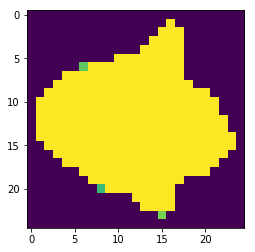

In [13]:
plt.imshow(cv2.resize(train_images[442], (25, 25)))

In [83]:
x, y = 64, 64

model = keras.Sequential()

model.add(keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(x, y, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(99, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])

reduced_train_images = np.concatenate(np.array([cv2.normalize(cv2.resize(img, (x, y)), dst=np.array([])).reshape(1, x, y, 1) for img in train_images]))

train_labels_categorical = keras.utils.to_categorical(train_labels_encoded, 99)

model.fit(reduced_train_images, train_labels_categorical, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Train on 792 samples, validate on 198 samples
Epoch 1/20
792/792 [==============================] - 8s 10ms/step - loss: 4.5951 - acc: 0.0051 - val_loss: 4.5952 - val_acc: 0.0000e+00
Epoch 2/20
792/792 [==============================] - 7s 9ms/step - loss: 4.5951 - acc: 0.0126 - val_loss: 4.5953 - val_acc: 0.0152
Epoch 3/20
792/792 [==============================] - 7s 9ms/step - loss: 4.5951 - acc: 0.0101 - val_loss: 4.5953 - val_acc: 0.0051
Epoch 4/20
792/792 [==============================] - 8s 10ms/step - loss: 4.5951 - acc: 0.0051 - val_loss: 4.5954 - val_acc: 0.0051
Epoch 5/20
792/792 [==============================] - 8s 9ms/step - loss: 4.5951 - acc: 0.0076 - val_loss: 4.5955 - val_acc: 0.0051
Epoch 6/20
792/792 [==============================] - 8s 10ms/step - loss: 4.5951 - acc: 0.0101 - val_loss: 4.5956 - val_acc: 0.0051
Epoch 7/20
792/792 [==============================] - 8s 10ms/step - loss: 4.5950 - acc: 0.0063 - val_loss: 4.5956 - val_acc: 0.0000e+00
Epoch 8/20
792/792

In [82]:
reduced_train_images.shape
# for i in reduced_train_images:
#     reduced_train_images[i] = reduced_train_images[i] / (reduced_train_images[i].sum()+1)

(990, 64, 64, 1)

In [43]:
cv2.resize(train_images[0], (25,25)).reshape((1, 25, 25)).shape

(1, 25, 25)

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 99)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class CNNClassifier(object):
    def __init__(self):
        self.model = CNN()
        
    def fit(self, X, y, epochs=2):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(zip(X, y), 0):
                # get the inputs
                inputs, labels = data
                
                inputs = torch.FloatTensor(cv2.resize(inputs, (22, 22)).reshape(1, 1, 22, 22))
                                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
                    
cnnClassifier = CNNClassifier()
# cnnClassifier.fit(train_images, train_labels_encoded)
cnnClassifier.fit(train_images, keras.utils.to_categoritrain_labels_encoded)

AttributeError: 'numpy.int64' object has no attribute 'requires_grad'

In [ ]:
np.array([np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]])]).shape

In [ ]:
# #predict using KNN
# preds_knn=knn_model.predict(test_data)
# #predict using SVM
# preds_svm=svm_model.decision_function(test_data)
# print np.array(preds_svm).shape

def generateSubmission(ids, test, model, num_classes):
    num_test = len(test)
    predictions = model.predict(test)
    confidence = model.predict_proba(test)
    output = np.zeros((num_test, num_classes+1))
    
    for i in xrange(num_test):
        p = predictions[i]
        c = confidence[i][p]
        #prob = c
        prob = min(max(10e-15, c), 1-10e-15)
        logLoss = np.log(prob)
        output[i][p+1] = -logLoss / num_test
        output[i][0] = ids[i]
    return output

In [ ]:
# out_file = generateSubmission(test_ids, test_data,svm_model,99)
headerRow=np.array(['id'] + le.inverse_transform(range(99)).tolist())
df = pd.DataFrame(data=out_file, columns = headerRow)
df['id'] = df['id'].astype(np.int)
df=df.set_index('id')
#print df.head()
# np.set_printoptions(threshold=np.inf)
# print out_file
df.to_csv('output/9_11_18_17.csv')